In [ ]:
# Environment setting for the notebook with python==3.11.10
%pip install \
xarray==2024.7.0 \
pandas==2.2.2 \
numpy==2.1.1 \
matplotlib==3.9.2 \
scipy==1.14.1 \
cartopy==0.23.0 \
geopandas==1.0.1 \
zarr==2.18.1 \
cmocean==4.0.3 \
s3fs==2024.10.0 \
seaborn==0.13.1 

Note: you may need to restart the kernel to use updated packages.


# ZARR Demo for the dataset of bom-reeftemp-dhd
#### This notebook demos how to use the Cloud Optimised Data (ZARR) of bom-reeftemp-dhd to extract and plot variables.

In [1]:
import xarray as xr
import s3fs 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import geopandas as gpd
from matplotlib.colors import ListedColormap
import pandas as pd
from shapely.geometry import box

### Functions to plot variables

In [46]:

def plot_timedelta_variable(
    ds: xr.Dataset, 
    selected_date: str, 
    variable_name: str
):
    """
    Plot the selected variable that is a timedelta64 datatype at the selected xarray dataset and date.
    
    Args:
    ds: xr.Dataset
    selected_date: str
    variable_name: str
    """
    
    # Convert the timedelta64 to the number of days
    array_var = ds.sel(time=selected_date)[variable_name] / np.timedelta64(1, 'D')
    array_var = array_var.squeeze()

    # Get lat/lon from zarr dataset
    lats = ds.lat.values
    lons = ds.lon.values

    # Create figure and axis
    plt.figure(figsize=(12, 8))
    
    title = f'{ds[variable_name].attrs["long_name"]}-{selected_date}'

    # Create heatmap with proper coordinates
    if len(array_var.shape) == 2:
        # Plot as heatmap if 2D using lat/lon
        plt.pcolormesh(lons, lats, array_var, 
                    cmap='RdYlBu_r',
                    shading='auto')
        plt.colorbar(label=variable_name)
    else:
        print('Variable is not 2D. Please check the variable dimensions.')

    # Customize plot
    plt.title(title)
    plt.xlabel('Longitude (°E)')
    plt.ylabel('Latitude (°S)')

    # Show plot
    plt.tight_layout()
    plt.show()
    


# The function refers the BOM austemp repo and modified for DHD plot by using zarr
# https://github.com/bomRob/austemp/blob/dev/src/plot_dhd.py
def plot_dhd_by_date(
    zarr, 
    variable,
    date, 
    lat_min, 
    lat_max, 
    lon_min, 
    lon_max, 
    title,
    output_file=None, 
    marine_parks_file=None
):
    """
    Plot the Degree Heating Days (DHD) data for a specific date by using zarr.
    
    Parameters:
        zarr (xr.Dataset): The xarray dataset containing the DHD data.
        variable (str): The variable name chose from zarr variables.
        date (str): The date in the format 'YYYY-MM-DD' to plot.
        lat_min (float): The minimum latitude for the plot domain.
        lat_max (float): The maximum latitude for the plot domain.
        lon_min (float): The minimum longitude for the plot domain.
        lon_max (float): The maximum longitude for the plot domain.
        output_file (str): The file path to save the plot as an image (e.g., 'dhd_plot.png').
        marine_parks_file (str): The file path to the marine parks shapefile for plotting.
    """

    # Define custom color palette for DHD plot
    ReeftempNG_DHD = [
        '#6B9E56', '#9EC08A', '#D1E2BE', '#FFFFCC', '#FFFF00', '#FFE900', 
        '#FFBF00', '#FF8A00', '#FF5F00', '#FF0900', '#EB0000', '#B30000', 
        '#890000', '#4C0000', '#390000', '#130000'
    ]

    # Define colorbar ticks for DHD plot
    colbar_ticks = np.arange(0, 170, 10)  # 0 to 160 in increments of 10

    # Define major cities with their latitudes and longitudes
    major_cities = [
        {"name": "Sydney", "lat": -33.8688, "lon": 151.2093},
        {"name": "Brisbane", "lat": -27.4698, "lon": 153.0251},
        {"name": "Perth", "lat": -31.9505, "lon": 115.8605},
        {"name": "Adelaide", "lat": -34.9285, "lon": 138.6007},
        {"name": "Darwin", "lat": -12.46113, "lon": 130.84185},
        {"name": "Townsville", "lat": -19.26639, "lon": 146.80569},
        {"name": "Cairns", "lat": -16.92366, "lon": 145.76613},
        {"name": "Rockhampton", "lat": -23.38032, "lon": 150.50595}
    ]


    plt.figure(figsize=(10, 8), dpi=120)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Select the DHD data for the given date and variable
    data = zarr.sel(time=date)[variable]

    # Set plot extent based on domain
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Squeeze to remove singleton dimensions
    data = data.squeeze()

    # Set DHD values of 0 to NaN, so they will be plotted as white
    data = data.where(data != 0, np.nan)

    # Set vmin and vmax for colorbar alignment
    vmin = 0
    vmax = 160

    # Plot the data with a custom colormap and custom colorbar ticks
    data.plot(ax=ax, cmap=ListedColormap(ReeftempNG_DHD), transform=ccrs.PlateCarree(), 
              vmin=vmin, vmax=vmax,  # Set the colorbar range
              cbar_kwargs={
                  'label': '(\u00b0C Days)',
                  'ticks': colbar_ticks  # Apply the custom ticks
              })
    
    # Add land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='#D3D3D3', zorder=100)
    ax.add_feature(cfeature.COASTLINE, zorder=101)

    # Add major cities to the plot if they are within the domain
    for city in major_cities:
        if lat_min <= city["lat"] <= lat_max and lon_min <= city["lon"] <= lon_max:
            # Plot black point for the city
            ax.plot(city["lon"], city["lat"], marker='o', color='black', markersize=5, 
                    transform=ccrs.PlateCarree(), zorder=110)
            
            # Add label to the left of the city point
            ax.text(city["lon"] - 0.2, city["lat"], city["name"], transform=ccrs.PlateCarree(), 
                    fontsize=10, verticalalignment='center', horizontalalignment='right', 
                    zorder=111, color='black')
    
    # Add marine park boundaries if provided
    if marine_parks_file is not None:
        marine_parks = gpd.read_file(marine_parks_file)

        # Filter for GBR and Australian EEZ parks
        marine_parks_gbr = marine_parks[marine_parks['NAME'].str.contains("Great Barrier Reef", case=False)]

        # Define bounding box for the lat/lon bounds
        bounding_box = box(lon_min, lat_min, lon_max, lat_max)
        
        # Clip the parks to the bounding box
        marine_parks_gbr_clipped = gpd.clip(marine_parks_gbr, bounding_box)

        # Plot the clipped marine parks
        ax.add_geometries(marine_parks_gbr_clipped.geometry, crs=ccrs.PlateCarree(), facecolor='none', 
                          edgecolor='black', linewidth=1, zorder=105, label='GBR Area')

    # Add grid labels
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=111)
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.left_labels = True   # Enable left labels (latitude)
    gl.bottom_labels = True  # Enable bottom labels (longitude)

    # Manually add a small legend in the bottom-left corner
    legend_x = 0.02  # x position of the legend box
    legend_y = 0.05  # y position of the legend box

    # Add a white box for "No Data"
    ax.add_patch(mpatches.Rectangle((legend_x, legend_y), 0.02, 0.02, transform=ax.transAxes, 
                                    color='white', ec='black', lw=1, zorder=112))
    ax.text(legend_x + 0.03, legend_y + 0.01, "No Data", transform=ax.transAxes, 
            fontsize=10, verticalalignment='center', zorder=113)

    # Add a light grey box for "Land"
    ax.add_patch(mpatches.Rectangle((legend_x, legend_y - 0.03), 0.02, 0.02, transform=ax.transAxes, 
                                    color='#D3D3D3', ec='black', lw=1, zorder=112))
    ax.text(legend_x + 0.03, legend_y - 0.02, "Land", transform=ax.transAxes, 
            fontsize=10, verticalalignment='center', zorder=113)

    # Add thick black border using plt.Rectangle
    rect = plt.Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                         linewidth=3, edgecolor='black', facecolor='none', zorder=120)
    ax.add_patch(rect)

    # Save the plot
    plt.title(title)
    
    if output_file is not None:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    # plt.close()

### Connect to the data of `bom-reeftemp-dhd` from s3

In [33]:
zarr_store = "s3://data-uplift-public/bom-reeftemp-dhd/data.zarr/"

fs = s3fs.S3FileSystem(anon=True)
data = xr.open_zarr(zarr_store, consolidated=True, storage_options={"anon": True})
data

<xarray.Dataset> Size: 96GB
Dimensions:           (time: 2679, lat: 800, lon: 700)
Coordinates:
  * lat               (lat) float32 3kB -25.49 -25.47 -25.45 ... -9.53 -9.51
  * lon               (lon) float32 3kB 142.0 142.0 142.1 ... 155.9 156.0 156.0
  * time              (time) datetime64[ns] 21kB 2002-03-19 ... 2024-03-31T15...
Data variables:
    dhd1              (time, lat, lon) float32 6GB ...
    dhd1_leg          (time, lat, lon) float32 6GB ...
    dhd_mosaic_imos   (time, lat, lon) float32 6GB ...
    dhd_mosaic_leg    (time, lat, lon) float32 6GB ...
    dhdc1             (time, lat, lon) timedelta64[ns] 12GB ...
    dhdc1_leg         (time, lat, lon) timedelta64[ns] 12GB ...
    dhdc_mosaic_imos  (time, lat, lon) timedelta64[ns] 12GB ...
    dhdc_mosaic_leg   (time, lat, lon) timedelta64[ns] 12GB ...
    mpsa1             (time, lat, lon) float32 6GB ...
    mpsa1_leg         (time, lat, lon) float32 6GB ...
    mpsa_mosaic_imos  (time, lat, lon) float32 6GB ...
    mpsa_mosaic_leg   (time, lat, lon) float32 6GB ...
Attributes: (12/32)
    Conventions:                CF-1.5
    acknowledgement:            HRPT AVHRR experimental SSTskin retrievals we...
    author:                     Luke Garde and Claire Spillman
    author_email:               l.garde@bom.gov.au ; c.spillman@bom.gov.au
    cdm_data_type:              grid
    comment:                    NetCDF file contains 1-day and 14-day mosaic ...
    ...                         ...
    source:                     AVHRR_D-ABOM-L2P-v01; ABOM-L4LRfnd-GLOB-GAMSS...
    spatial_resolution:         0.02
    start_time:                 20190119T085711Z
    stop_time:                  20190119T213711Z
    summary:                    ReefTemp Next Generation is a specialised rem...
    title:                      Nighttime Reeftemp: Next Generation (RTNG) DH...

#### Quick plot numerical variable of the latest datetime

dhd1


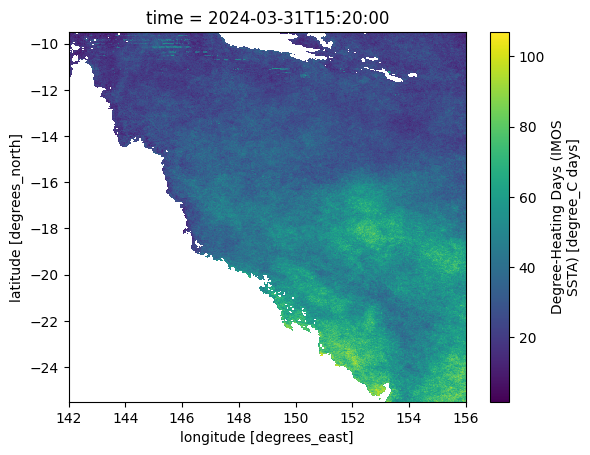

dhd1_leg


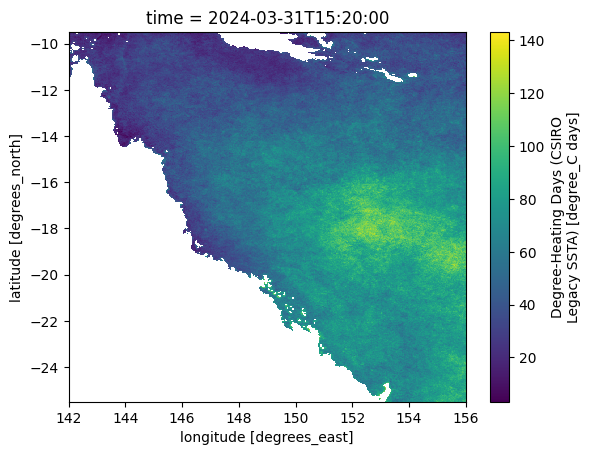

dhd_mosaic_imos


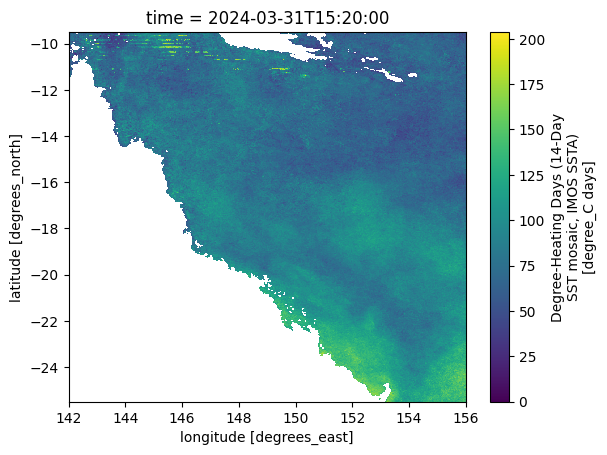

dhd_mosaic_leg


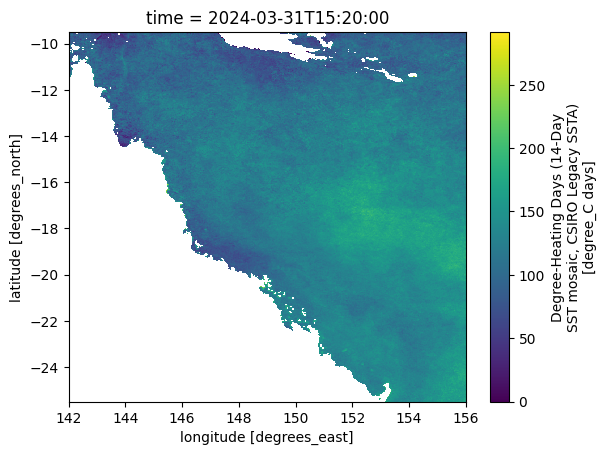

dhdc1
dhdc1_leg
dhdc_mosaic_imos
dhdc_mosaic_leg
mpsa1


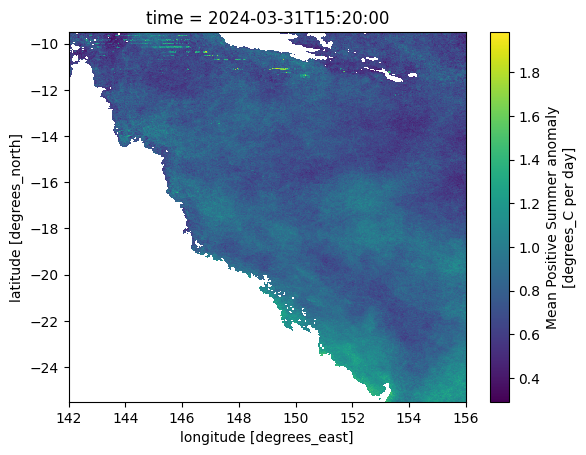

mpsa1_leg


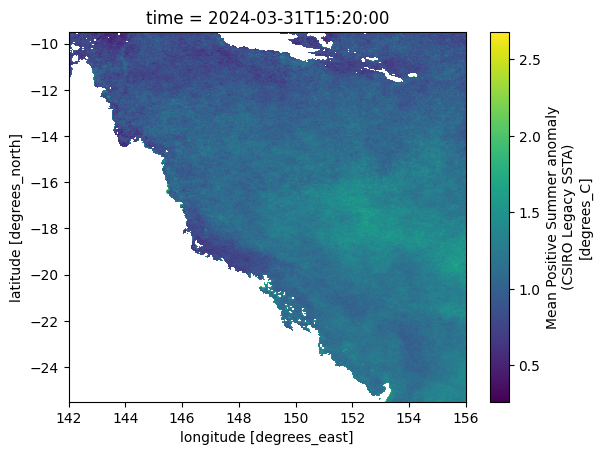

mpsa_mosaic_imos


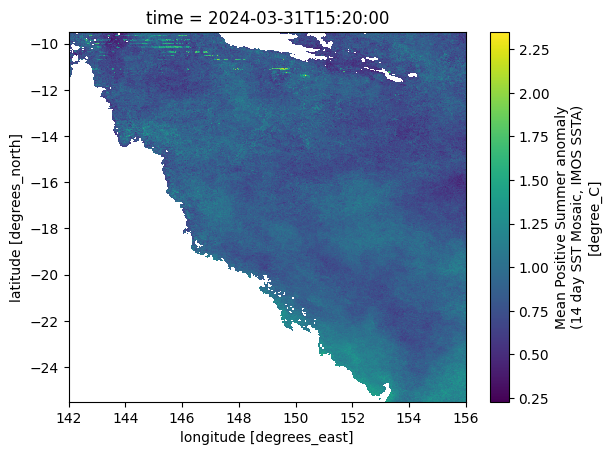

mpsa_mosaic_leg


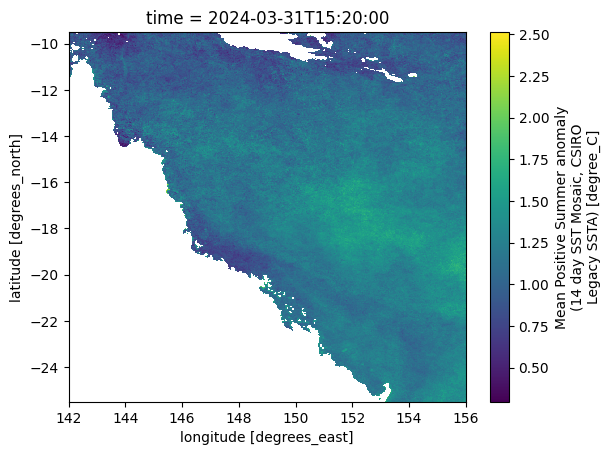

In [34]:
for var in data.data_vars:
    print(var)
    try:
        data[var].isel(time=-1).plot()
        plt.show()
    except:
        # "Variable {var} is not numerical datatype. Skipping plot."
        continue

### Plot Nonnumerical Variables (timedelta64 datatype) of `"dhdc1", "dhdc1_leg", "dhdc_mosaic_imos", "dhdc_mosaic_leg"`

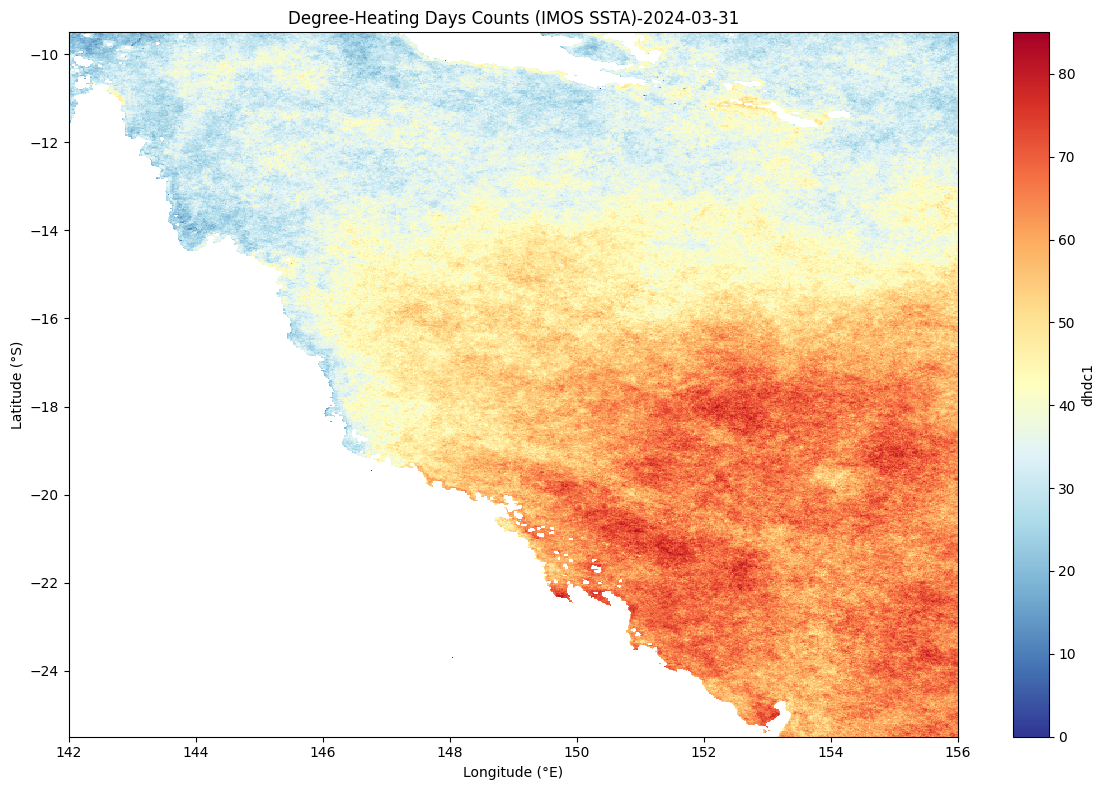

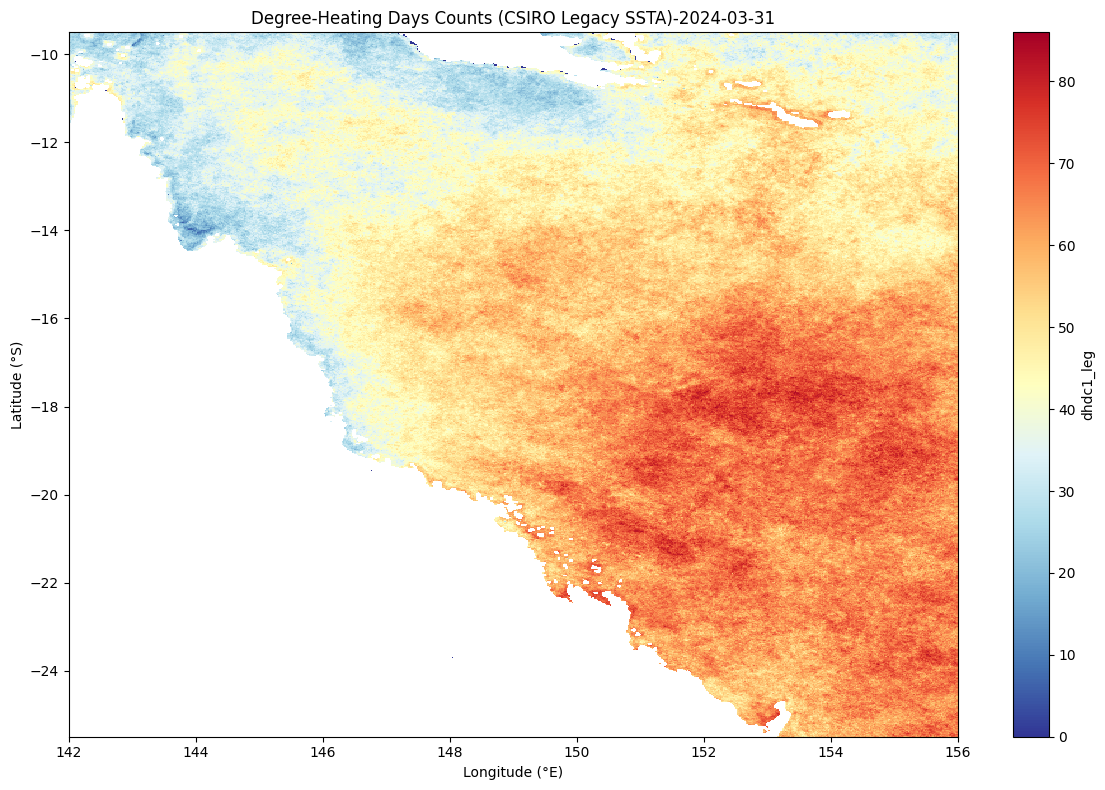

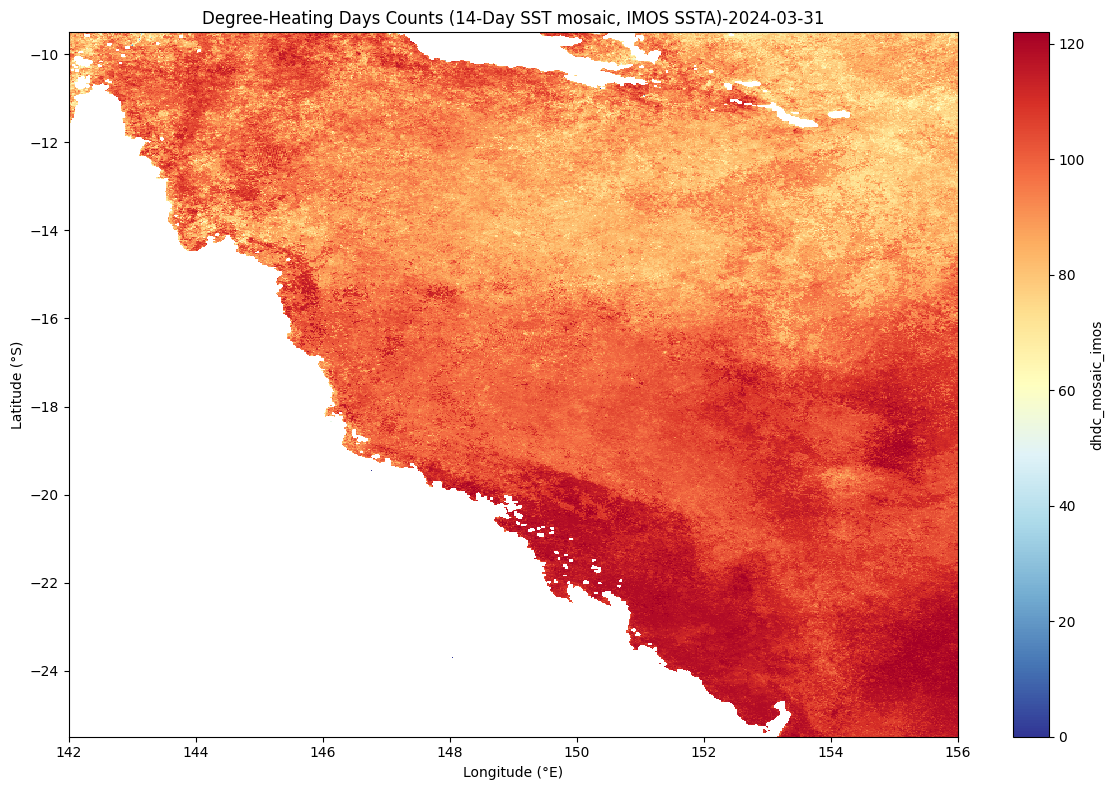

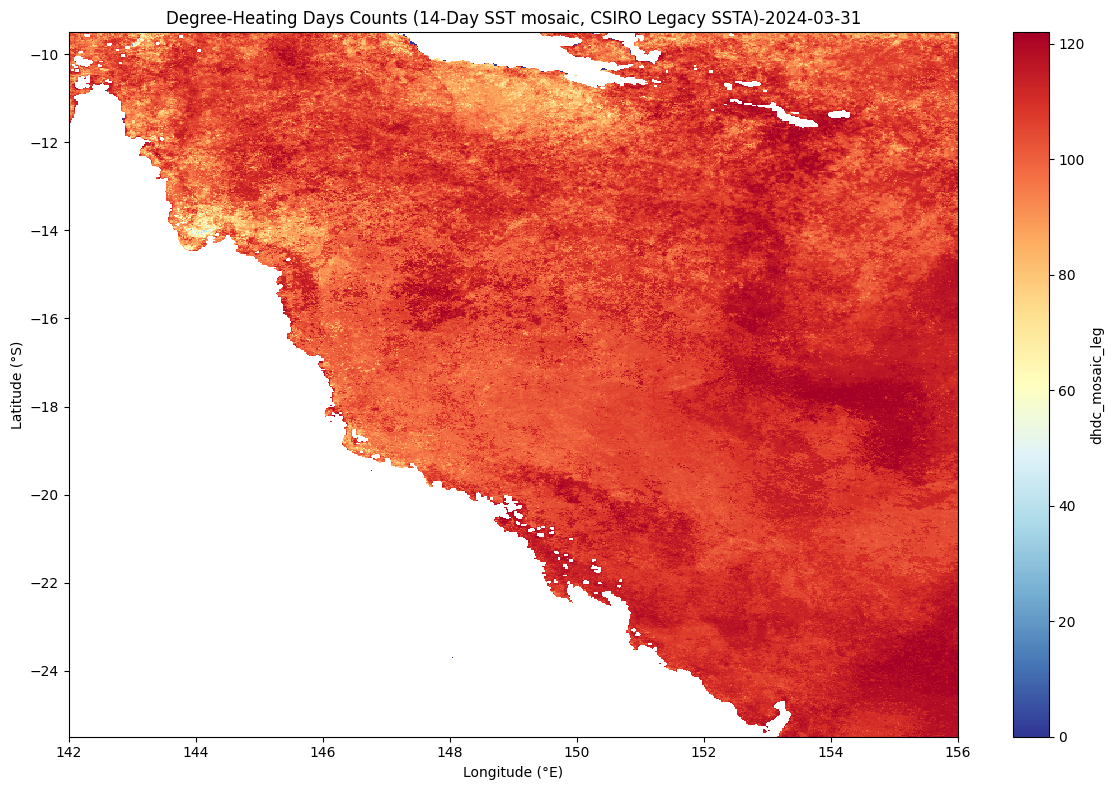

In [35]:
selected_date = '2024-03-31'

timedelta_var_list = ["dhdc1", "dhdc1_leg", "dhdc_mosaic_imos", "dhdc_mosaic_leg"]

for variable_name in timedelta_var_list:

    plot_timedelta_variable(data, selected_date, variable_name)

#### Analyst a week temperature changes for the variable `dhd1` on GBR region

In [36]:

dhd1_202403 = data.sel(time=slice('2024-03-01', '2024-03-07')).dhd1
dhd1_202403

<xarray.DataArray 'dhd1' (time: 7, lat: 800, lon: 700)> Size: 16MB
[3920000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 3kB -25.49 -25.47 -25.45 -25.43 ... -9.55 -9.53 -9.51
  * lon      (lon) float32 3kB 142.0 142.0 142.1 142.1 ... 155.9 156.0 156.0
  * time     (time) datetime64[ns] 56B 2024-03-01T15:20:00 ... 2024-03-07T15:...
Attributes:
    comment:                Degree-Heating Days
    feature_id:             http://sweet.jpl.nasa.gov/2.2/realmOcean.owl#Ocea...
    long_name:              Degree-Heating Days (IMOS SSTA)
    medium_id:              http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SeaWater
    procedure_id:           Sum_SSTA_IMOS
    scaledQuantityKind_id:  http://environment.data.gov.au/water/quality/def/...
    substanceOrTaxon_id:    http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SaltW...
    unit_id:                http://environment.data.gov.au/water/quality/def/...
    units:                  degree_C days
    valid_max:              500
    valid_min:              0

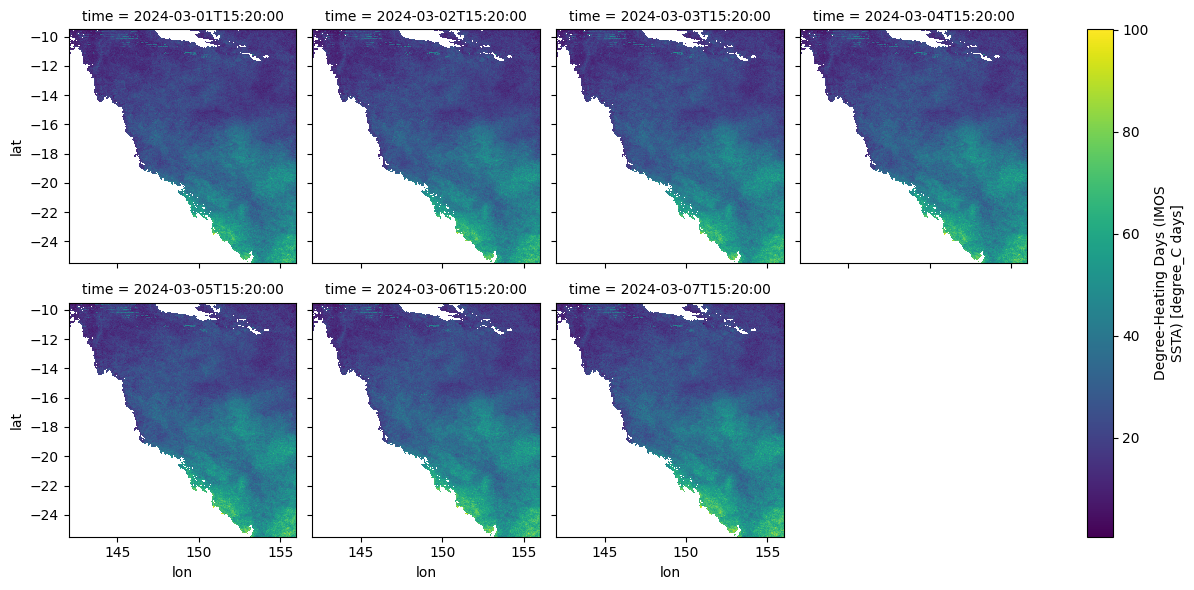

In [37]:
dhd1_202403.plot(col='time', col_wrap=4)

#### Quick plot of the `dhd1` located at `Square Reef`
Google Map of `Square Reef` : https://www.google.com/maps/place/20%C2%B000'00.0%22S+150%C2%B000'00.0%22E/@-20.0534848,149.7645284,13.07z/data=!4m4!3m3!8m2!3d-20!4d150?authuser=0&entry=ttu&g_ep=EgoyMDI0MTIwMy4wIKXMDSoASAFQAw%3D%3D

In [38]:
Square_Reef_dhd1_2024 = data.sel(lat=-20.067047, lon=149.812109, method="nearest")\
    .sel(time=slice('2023-12-01', '2024-3-31'))\
    .dhd1
Square_Reef_dhd1_2024

<xarray.DataArray 'dhd1' (time: 122)> Size: 488B
[122 values with dtype=float32]
Coordinates:
    lat      float32 4B -20.07
    lon      float32 4B 149.8
  * time     (time) datetime64[ns] 976B 2023-12-01T15:20:00 ... 2024-03-31T15...
Attributes:
    comment:                Degree-Heating Days
    feature_id:             http://sweet.jpl.nasa.gov/2.2/realmOcean.owl#Ocea...
    long_name:              Degree-Heating Days (IMOS SSTA)
    medium_id:              http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SeaWater
    procedure_id:           Sum_SSTA_IMOS
    scaledQuantityKind_id:  http://environment.data.gov.au/water/quality/def/...
    substanceOrTaxon_id:    http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SaltW...
    unit_id:                http://environment.data.gov.au/water/quality/def/...
    units:                  degree_C days
    valid_max:              500
    valid_min:              0

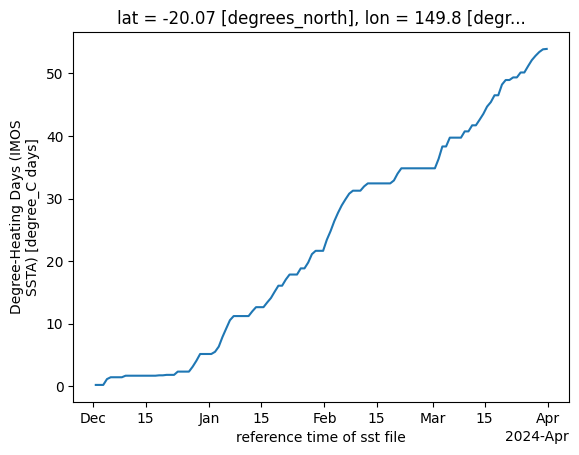

In [39]:
Square_Reef_dhd1_2024.plot()

#### Quick plot every variable of the whole year of 2024 located at `Square Reef`

dhd1


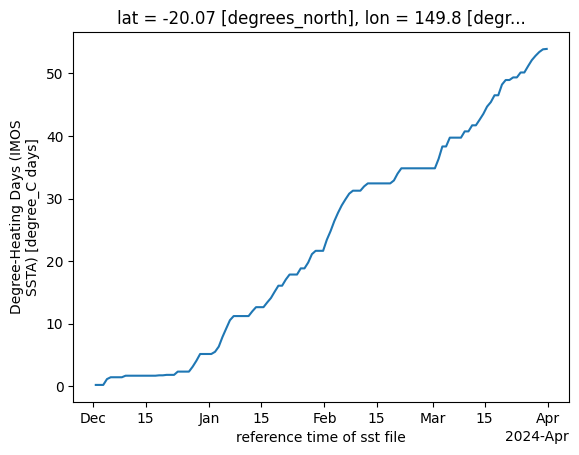

dhd1_leg


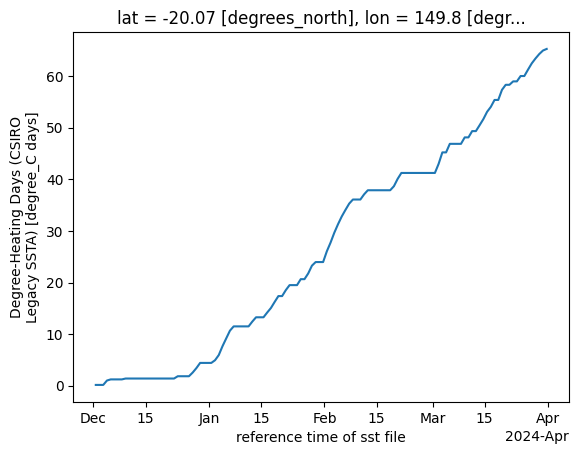

dhd_mosaic_imos


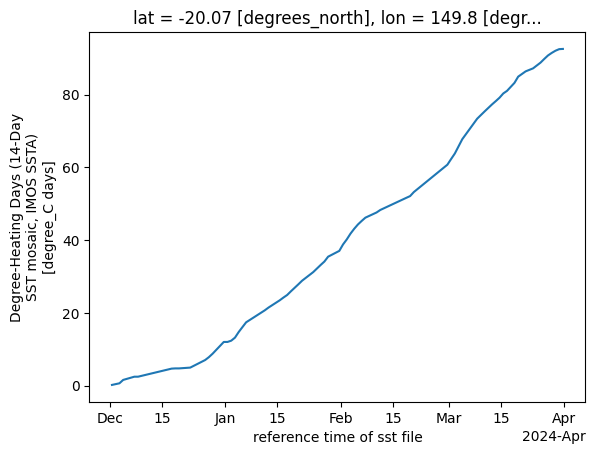

dhd_mosaic_leg


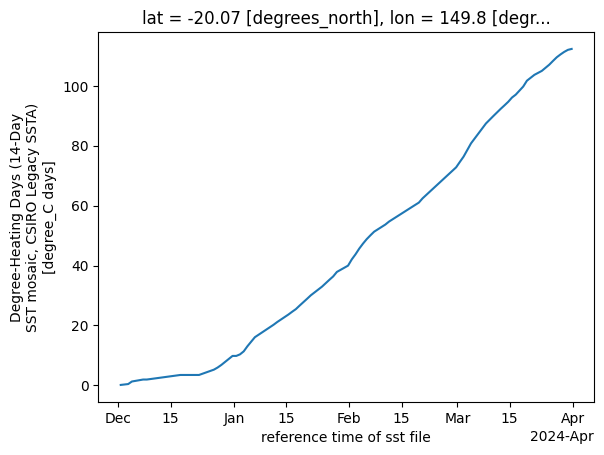

dhdc1


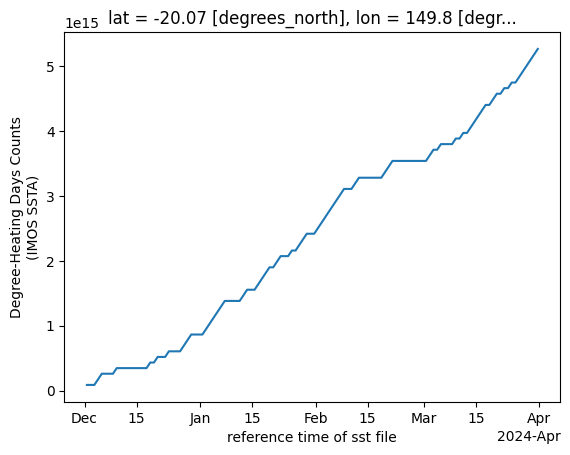

dhdc1_leg


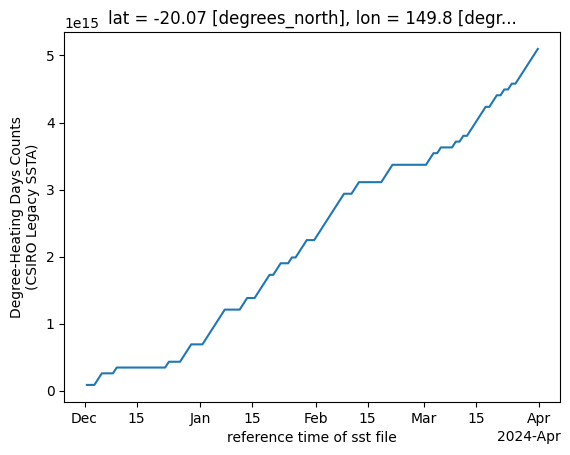

dhdc_mosaic_imos


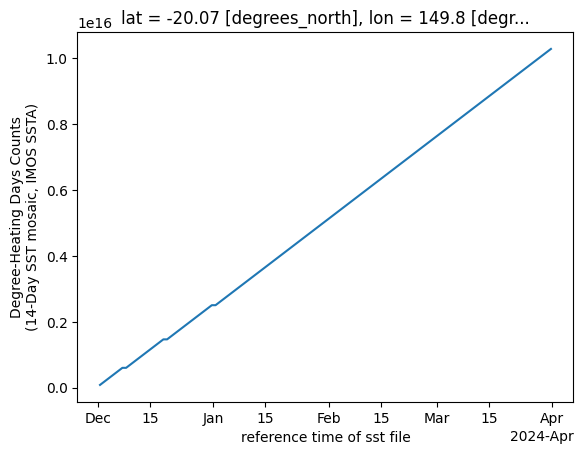

dhdc_mosaic_leg


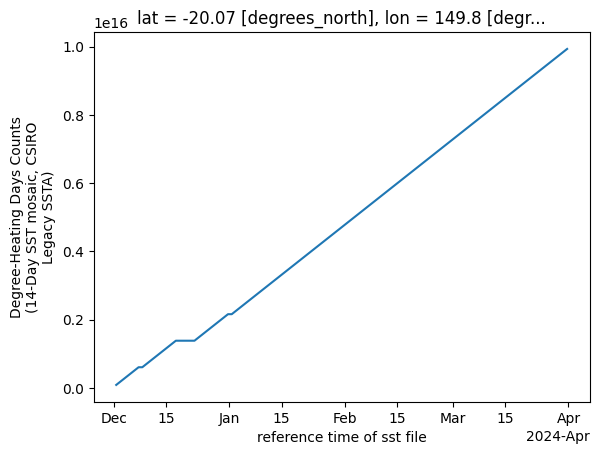

mpsa1


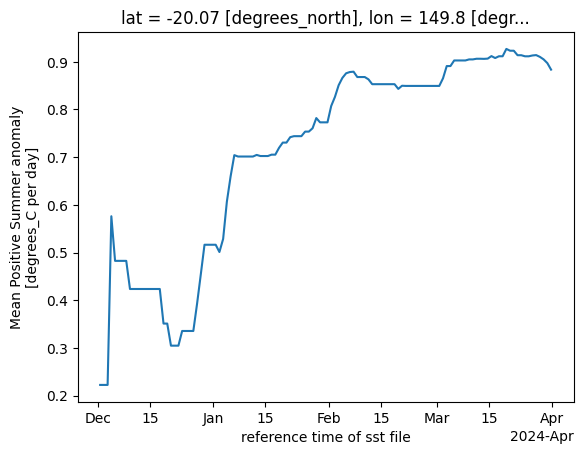

mpsa1_leg


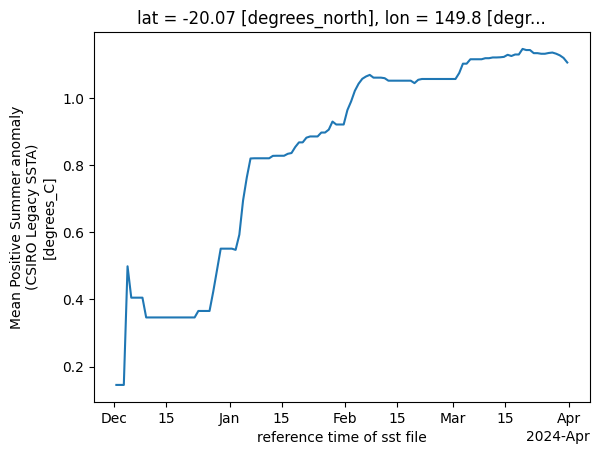

mpsa_mosaic_imos


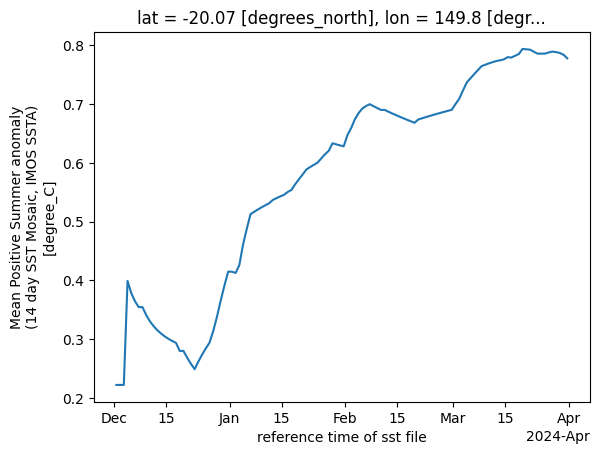

mpsa_mosaic_leg


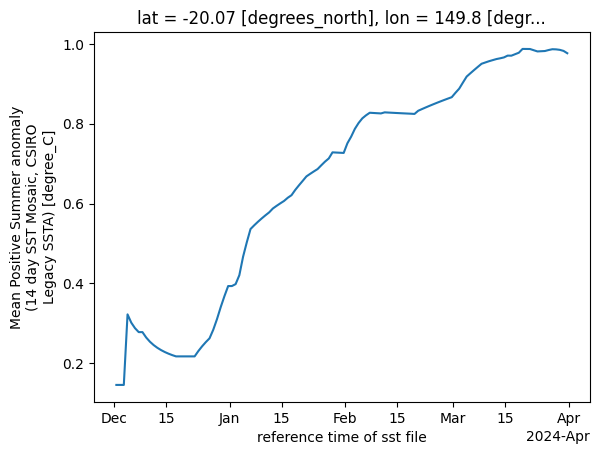

In [40]:
for var in data.data_vars:
    print(var)
    try:
        data[var].sel(lat=-20.067047, lon=149.812109, method="nearest")\
        .sel(time=slice('2023-12-01', '2024-3-31'))\
        .plot()
        plt.show()
    except:
        print(f"Could not plot {var}")
        continue

### Check the calculations using the entire grid
Below, we will create a new variable that will contain the `dhd1` data for 2024. 

We will then calculate a monthly mean and finally we plot the results to see the monthly mean temperature.

In [41]:
# Check the grouping and caculate speed with a whole year
dhd1_2024 = data.dhd1.sel(time=slice('2023-12-01', '2024-03-31'))
dhd1_2024

<xarray.DataArray 'dhd1' (time: 122, lat: 800, lon: 700)> Size: 273MB
[68320000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 3kB -25.49 -25.47 -25.45 -25.43 ... -9.55 -9.53 -9.51
  * lon      (lon) float32 3kB 142.0 142.0 142.1 142.1 ... 155.9 156.0 156.0
  * time     (time) datetime64[ns] 976B 2023-12-01T15:20:00 ... 2024-03-31T15...
Attributes:
    comment:                Degree-Heating Days
    feature_id:             http://sweet.jpl.nasa.gov/2.2/realmOcean.owl#Ocea...
    long_name:              Degree-Heating Days (IMOS SSTA)
    medium_id:              http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SeaWater
    procedure_id:           Sum_SSTA_IMOS
    scaledQuantityKind_id:  http://environment.data.gov.au/water/quality/def/...
    substanceOrTaxon_id:    http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SaltW...
    unit_id:                http://environment.data.gov.au/water/quality/def/...
    units:                  degree_C days
    valid_max:              500
    valid_min:              0

In [42]:
dhd1_2024_monthly = dhd1_2024.groupby("time.month").mean()
dhd1_2024_monthly

<xarray.DataArray 'dhd1' (month: 4, lat: 800, lon: 700)> Size: 9MB
array([[[        nan,         nan,         nan, ..., 33.373516  ,
         33.633347  , 33.364613  ],
        [        nan,         nan,         nan, ..., 34.066994  ,
         34.035587  , 31.358578  ],
        [        nan,         nan,         nan, ..., 33.350574  ,
         27.680433  , 30.94243   ],
        ...,
        [ 1.0443887 ,  3.8893347 ,  5.43486   , ...,  8.335383  ,
          6.862909  ,  7.7397637 ],
        [ 1.8723856 ,  4.7483463 ,  4.052666  , ...,  7.712491  ,
          8.021898  ,  8.290254  ],
        [ 2.5676396 ,  3.1976545 ,  6.742722  , ...,  6.3132815 ,
          6.074759  ,  6.2708764 ]],

       [[        nan,         nan,         nan, ..., 52.875626  ,
         52.72832   , 53.74289   ],
        [        nan,         nan,         nan, ..., 55.83264   ,
         53.664524  , 51.581245  ],
        [        nan,         nan,         nan, ..., 53.108356  ,
         46.387535  , 51.67024   ],
...
        [ 7.5896854 , 10.919652  , 13.733423  , ..., 15.742646  ,
         12.629169  , 13.100265  ],
        [ 8.828914  , 14.512484  , 13.242059  , ..., 16.28565   ,
         14.8880005 , 15.332684  ],
        [ 7.893527  ,  6.964986  , 13.0609865 , ..., 13.742129  ,
         11.972846  , 12.464025  ]],

       [[        nan,         nan,         nan, ..., 10.795003  ,
         10.864651  , 11.534684  ],
        [        nan,         nan,         nan, ..., 10.452632  ,
         11.131154  , 10.632729  ],
        [        nan,         nan,         nan, ...,  9.593336  ,
          7.3482385 ,  8.378127  ],
        ...,
        [ 0.12682344,  1.0848647 ,  1.6167816 , ...,  0.99385095,
          0.37210363,  0.3520438 ],
        [ 0.25594693,  1.5107085 ,  1.4262244 , ...,  0.49368155,
          0.5646793 ,  0.38241127],
        [ 0.51872617,  1.0065547 ,  2.1413808 , ...,  0.8916938 ,
          0.50266373,  0.34442744]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 3kB -25.49 -25.47 -25.45 -25.43 ... -9.55 -9.53 -9.51
  * lon      (lon) float32 3kB 142.0 142.0 142.1 142.1 ... 155.9 156.0 156.0
  * month    (month) int64 32B 1 2 3 12
Attributes:
    comment:                Degree-Heating Days
    feature_id:             http://sweet.jpl.nasa.gov/2.2/realmOcean.owl#Ocea...
    long_name:              Degree-Heating Days (IMOS SSTA)
    medium_id:              http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SeaWater
    procedure_id:           Sum_SSTA_IMOS
    scaledQuantityKind_id:  http://environment.data.gov.au/water/quality/def/...
    substanceOrTaxon_id:    http://sweet.jpl.nasa.gov/2.2/matrWater.owl#SaltW...
    unit_id:                http://environment.data.gov.au/water/quality/def/...
    units:                  degree_C days
    valid_max:              500
    valid_min:              0

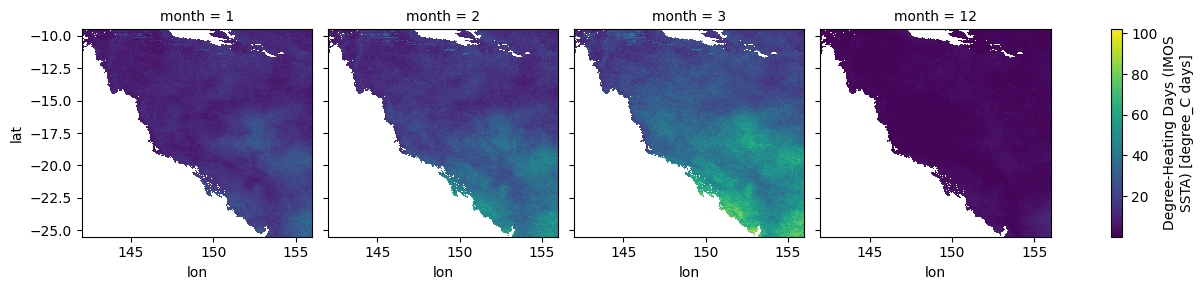

In [43]:
dhd1_2024_monthly.plot(col='month', col_wrap=4)

In [44]:
data_size = data.nbytes / 1e9
print(f"The data size is {data_size} GB")

The data size is 96.015387432 GB


## The demo for BOM DHD plotting by using zarr

Plot saved to dhd_plot_2024-03-30.png


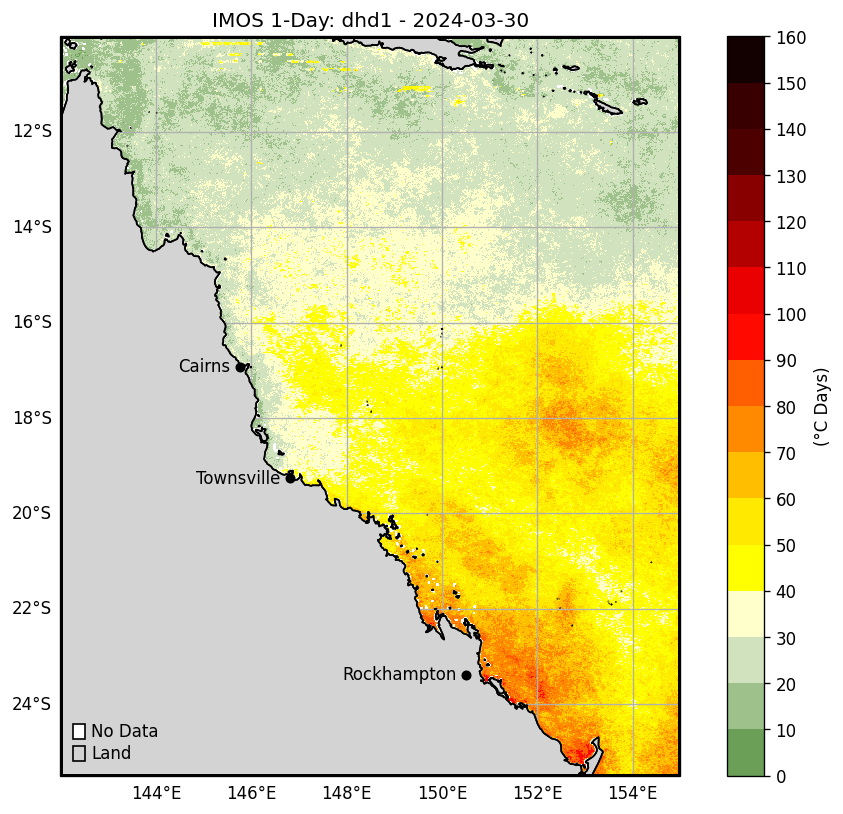

In [47]:
# Plot the variable "DHD" for a specific date from zarr

selected_date = "2024-03-30"
variable = "dhd1"
output_file = f"dhd_plot_{selected_date}.png"
title = f"IMOS 1-Day: { variable} - {selected_date}"


# Define the domain (GBR REGION) for the plot
lat_min = -25.5
lat_max = -10.0
lon_min = 142.0
lon_max = 155.0

plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

Plot saved to dhd_plot_2024-03-30.png


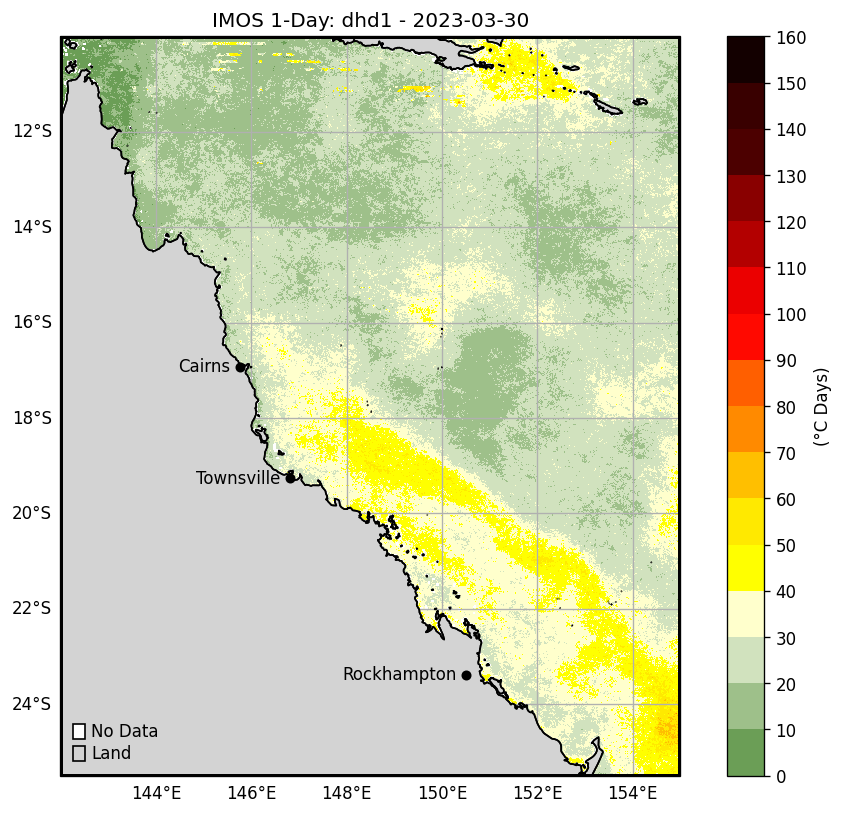

In [48]:
selected_date = "2023-03-30"
variable = "dhd1"

title = f"IMOS 1-Day: { variable} - {selected_date}"
plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

# Plot the variable "dhd_mosaic_imos" for a specific date from zarr

Plot saved to dhd_mosaic_plot_2024-03-30.png


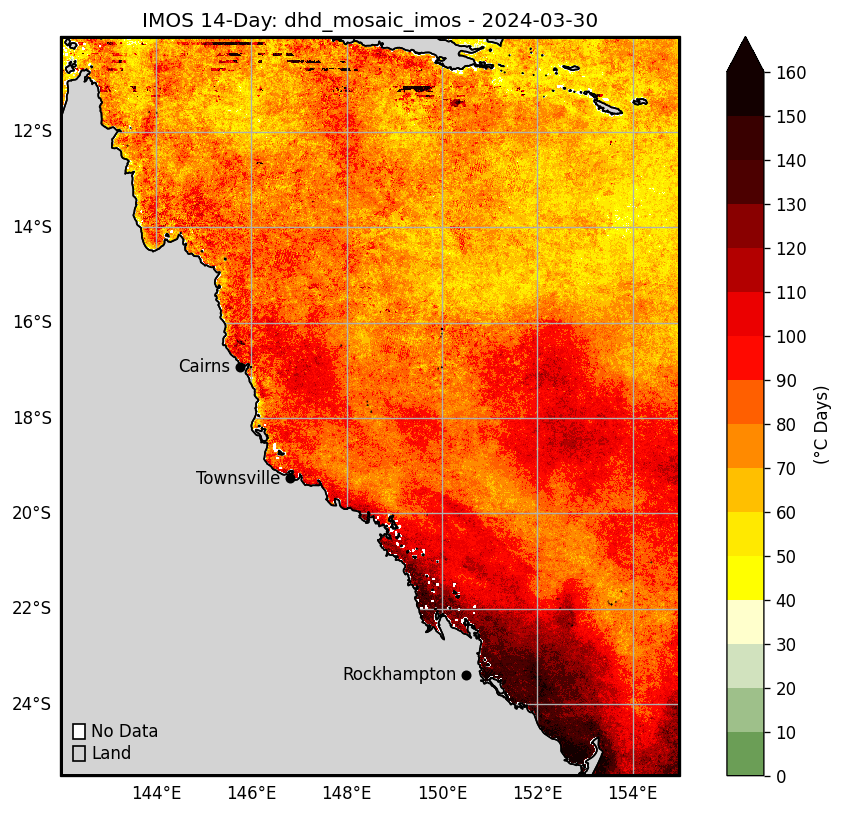

In [53]:

selected_date = "2024-03-30"
variable = "dhd_mosaic_imos"
output_file = f"dhd_mosaic_plot_{selected_date}.png"
title = f"IMOS 14-Day: { variable} - {selected_date}"
plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

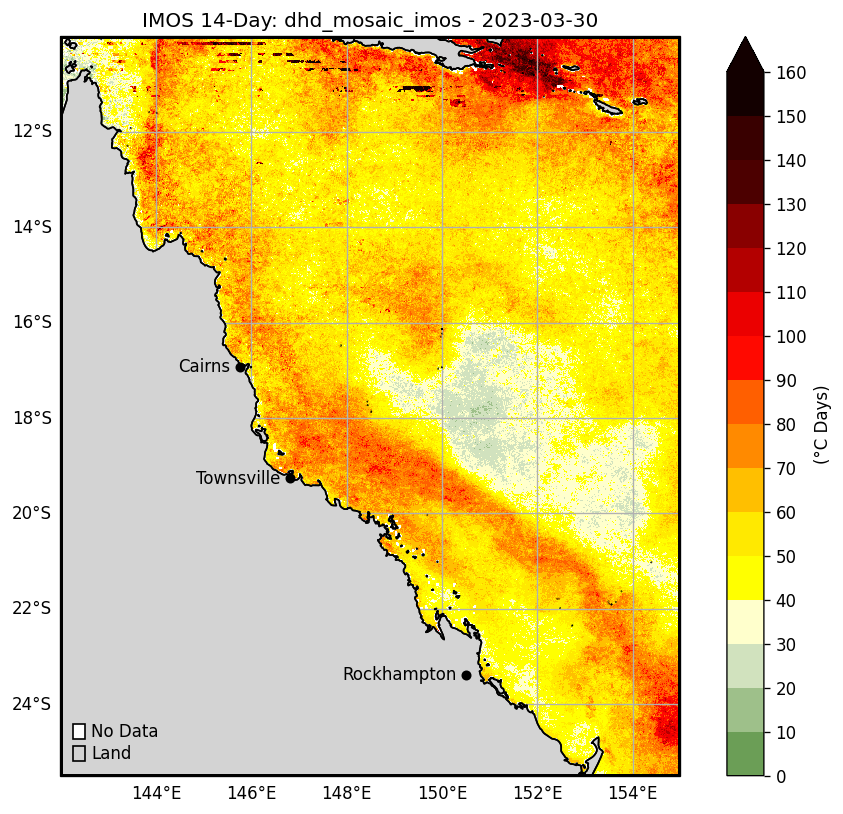

In [54]:
selected_date = "2023-03-30"
variable = "dhd_mosaic_imos"
title = f"IMOS 14-Day: { variable} - {selected_date}"
plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title)

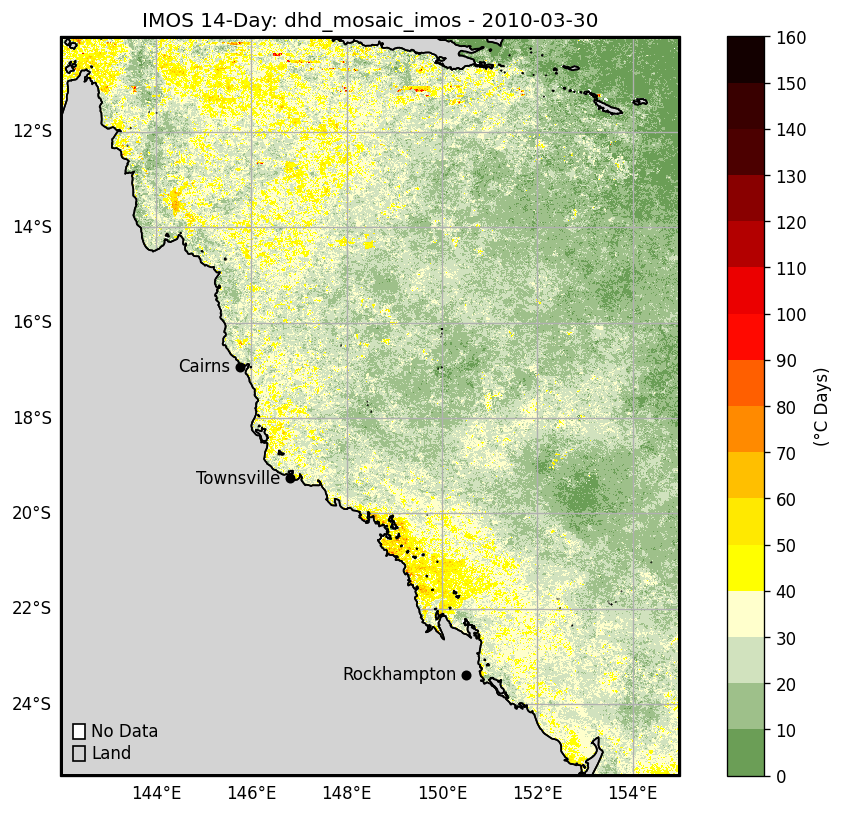

In [55]:
selected_date = "2010-03-30"
variable = "dhd_mosaic_imos"

title = f"IMOS 14-Day: { variable} - {selected_date}"
plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title)